<a href="https://colab.research.google.com/github/AsherReedy/Monte-Carlo-iRisk-Lab-Meetings-and-Homework/blob/main/IRisk_Meeting07_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IRisk Meeting 07: Time Series Models and Monte Carlo


## Objectives
- Define trend, seasonality, stationarity, and autocorrelation.
- Simulate and visualize white noise, random walk, ARIMA(1,1,0), and ARCH(1).
- Compare European call pricing under iid, AR(1) returns, and ARCH(1) variance.
- Answer brief knowledge checks and a short homework.


## 1. Imports and helpers

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(77285)

def lineplot(y, title=None, xlabel=None, ylabel=None):
    plt.figure()
    plt.plot(y)
    if title: plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    plt.show()

def acf_values(x, max_lag=24):
    x = np.asarray(x)
    x = x - np.mean(x)
    denom = np.sum(x**2)
    acf = [1.0]
    for k in range(1, max_lag+1):
        num = np.sum(x[k:] * x[:-k])
        acf.append(0.0 if denom == 0 else num/denom)
    return np.array(acf)

def acf_plot(x, max_lag=24, title=None):
    a = acf_values(x, max_lag=max_lag)
    lags = np.arange(max_lag+1)
    plt.figure()
    plt.stem(lags, a, use_line_collection=True)
    if title: plt.title(title)
    plt.xlabel("Lag"); plt.ylabel("ACF"); plt.show()

## 2. Global parameters

In [62]:
N = 600            # length for synthetic series and simulations
SIGMA = 1.0        # base shock std
SEASON_PERIOD = 50 # seasonality demo

# Option-pricing parameters
PHI = 0.6          # AR(1) coefficient for returns
OMEGA = 2e-6       # ARCH(1) omega
ALPHA = 0.9        # ARCH(1) alpha (alpha<1)
DT = 1/252         # daily step
S0 = 100.0
R = 0.02           # annual risk-free rate
T_days = 252       # horizon in trading days (~1 year)
M = 10000          # Monte Carlo paths
K = 100.0          # strike

N, SIGMA, SEASON_PERIOD, PHI, OMEGA, ALPHA, DT, S0, R, T_days, M, K

(600,
 1.0,
 50,
 0.6,
 2e-06,
 0.9,
 0.003968253968253968,
 100.0,
 0.02,
 252,
 10000,
 100.0)

## 3. Definitions with visuals
Trend: long-run movement.  
Seasonality: repeating pattern with a fixed period.  
Stationarity (weak): constant mean and variance; autocovariance depends only on lag.  
Autocorrelation: correlation between values k periods apart.  
ACF: autocorrelation function - plots autocorrelations with different lags

$r_1=r(x_t,x_{t-1}), r_2 = r(x_t,x_{t-2}),...$


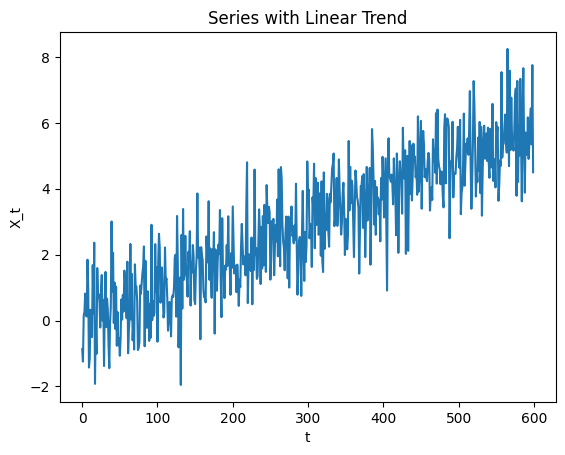

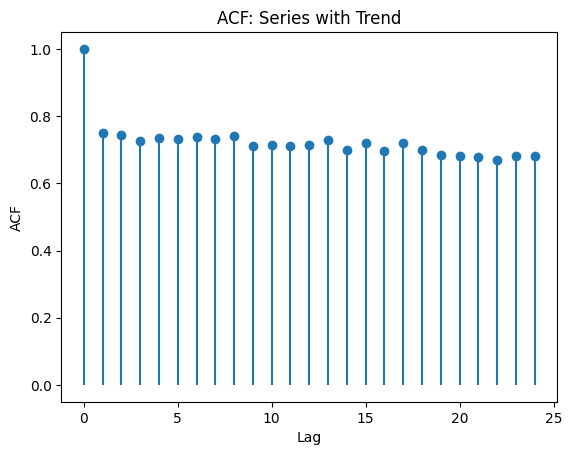

Positive ACF because small values clump (early time) and large values clump (later times)


In [63]:
t = np.arange(N)
trend = 0.01 * t
noise = np.random.normal(0, SIGMA, N)
series_trend = trend + noise

# Plot the time series
lineplot(series_trend, title="Series with Linear Trend", xlabel="t", ylabel="X_t")

# Updated ACF plot function for compatibility
def acf_plot(x, max_lag=24, title=None):
    acf = acf_values(x, max_lag=max_lag)
    lags = np.arange(max_lag + 1)
    plt.figure()
    # remove deprecated argument
    plt.stem(lags, acf, basefmt=" ")
    if title:
        plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.show()

# Plot ACF for the series
acf_plot(series_trend, max_lag=24, title="ACF: Series with Trend")
print("Positive ACF because small values clump (early time) and large values clump (later times)")

Seasonality - a repeated pattern. This case looks similar to a sin curve!

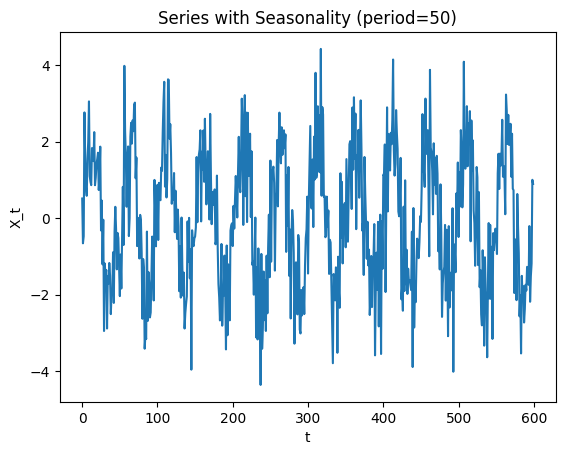

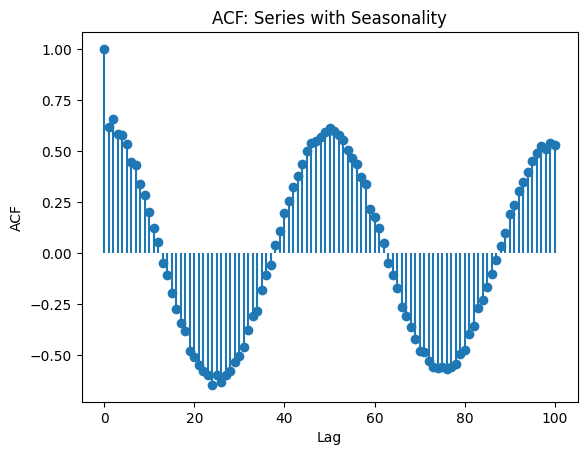

In [64]:
season = 2.0 * np.sin(2*np.pi*t/SEASON_PERIOD)
series_season = season + np.random.normal(0, SIGMA, N)
lineplot(series_season, title=f"Series with Seasonality (period={SEASON_PERIOD})", xlabel="t", ylabel="X_t")
acf_plot(series_season, max_lag=2*SEASON_PERIOD, title="ACF: Series with Seasonality")

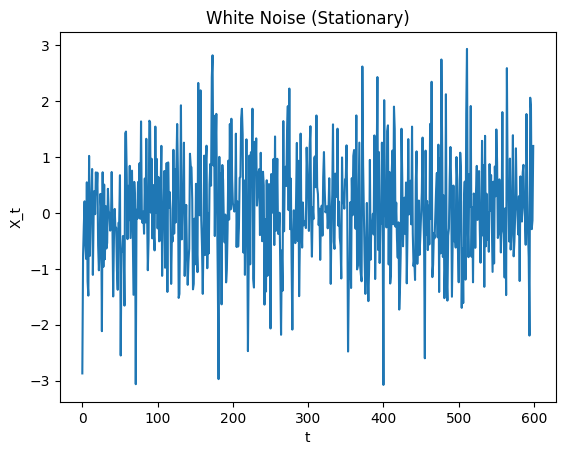

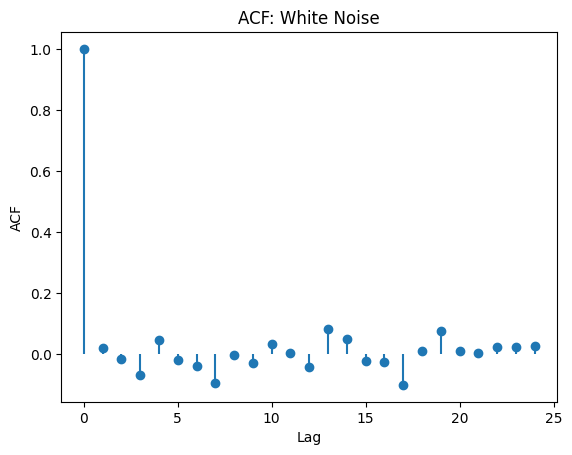

Zero ACF (except at zero!) because points are not related


In [65]:
stationary = np.random.normal(0, SIGMA, N)
lineplot(stationary, title="White Noise (Stationary)", xlabel="t", ylabel="X_t")
acf_plot(stationary, max_lag=24, title="ACF: White Noise")
print("Zero ACF (except at zero!) because points are not related")

### Knowledge check 3.A
1) Which example is stationary?  
2) What ACF feature signals seasonality?  
3) Why does a trend create a slow ACF decay?


In [66]:
# @title
#print("1) White noise; the others are not in levels.")
#print("2) Peaks at multiples of the seasonal period.")
#print("3) Levels remain correlated over long horizons when a trend exists.")

## 4. Model graphs

### 4.1 White Noise

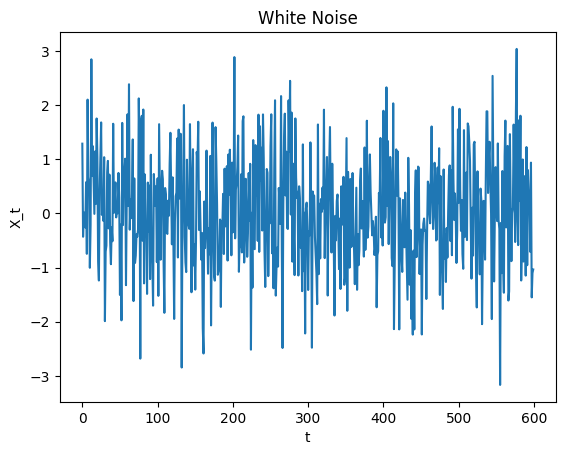

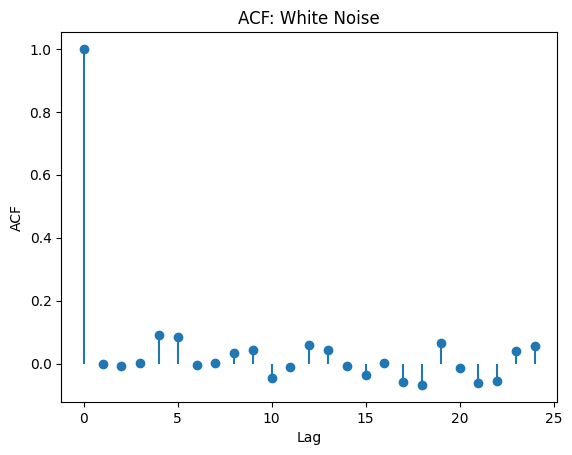

In [67]:
wn = np.random.normal(0, SIGMA, N)
lineplot(wn, title="White Noise", xlabel="t", ylabel="X_t")
acf_plot(wn, max_lag=24, title="ACF: White Noise")

### 4.2 Random Walk

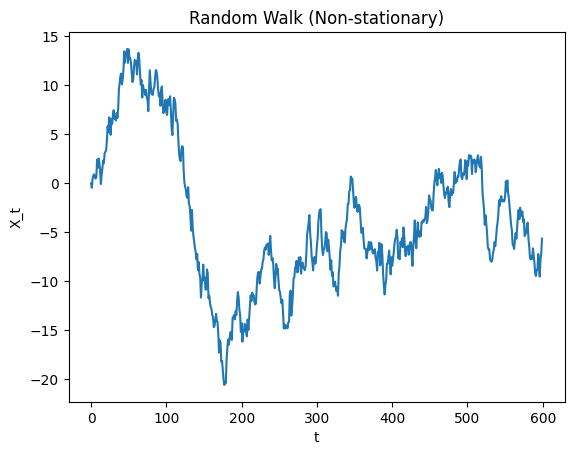

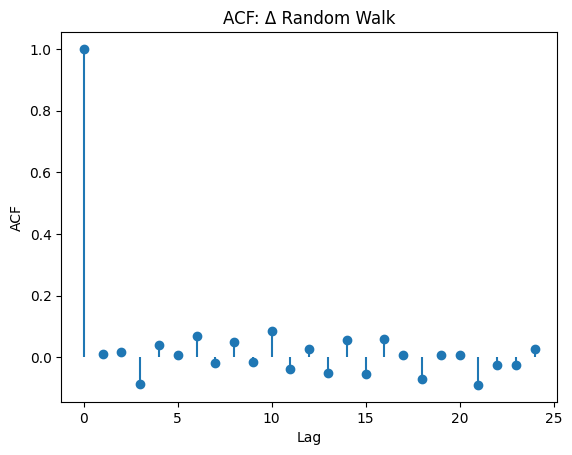

In [68]:
rw = np.zeros(N)
eps = np.random.normal(0, SIGMA, N)
for i in range(1, N):
    rw[i] = rw[i-1] + eps[i]
lineplot(rw, title="Random Walk (Non-stationary)", xlabel="t", ylabel="X_t")
acf_plot(np.diff(rw), max_lag=24, title="ACF: Δ Random Walk")

### 4.3 ARIMA(1,1,0) via AR(1) on differences

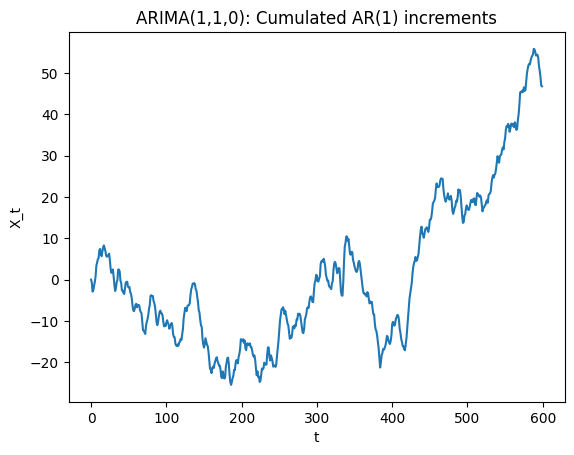

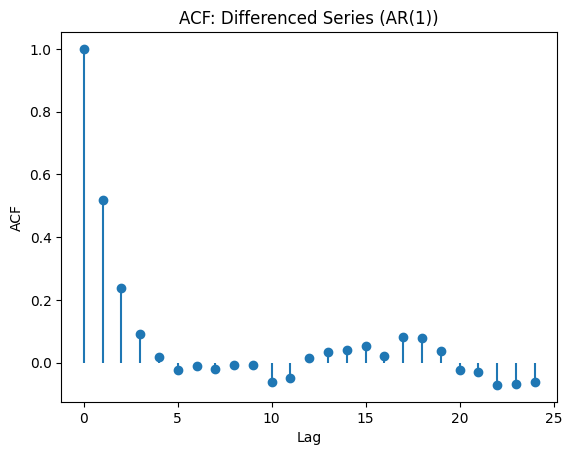

Autocorrelations decay


In [69]:
phi = .5
eps = np.random.normal(0, SIGMA, N)
dX = np.zeros(N)
for j in range(1, N):
    dX[j] = phi * dX[j-1] + eps[j]
X = np.cumsum(dX)
lineplot(X, title="ARIMA(1,1,0): Cumulated AR(1) increments", xlabel="t", ylabel="X_t")
acf_plot(dX, max_lag=24, title="ACF: Differenced Series (AR(1))")
print("Autocorrelations decay")

### 4.4 ARCH(1)

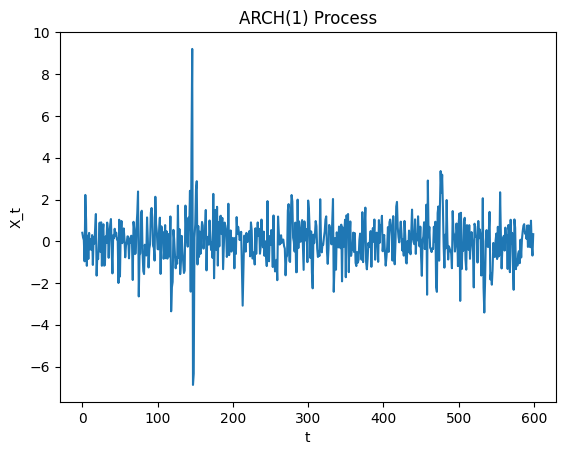

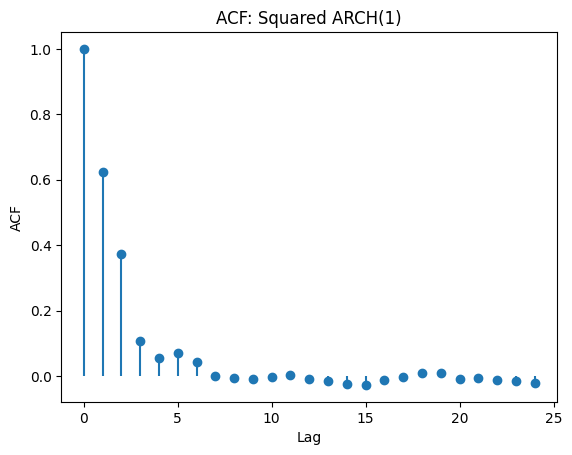

In [70]:
omega = 0.5
alpha = 0.4
z = np.random.normal(0, 1, N)
sigma2 = np.zeros(N)
x_arch = np.zeros(N)
sigma2[0] = omega/(1-alpha) if alpha < 1 else 1.0
x_arch[0] = np.sqrt(sigma2[0]) * z[0]
for j in range(1, N):
    sigma2[j] = omega + alpha * (x_arch[j-1]**2)
    x_arch[j] = np.sqrt(sigma2[j]) * z[j]

lineplot(x_arch, title="ARCH(1) Process", xlabel="t", ylabel="X_t")
acf_plot(x_arch**2, max_lag=24, title="ACF: Squared ARCH(1)")

### Knowledge check 4.B
1) Which series above are stationary in levels?  
2) Why examine the ACF of squared values for ARCH?


In [71]:
# @title
#print("1) White noise; RW and ARIMA levels are non-stationary. ARCH can be strictly stationary under parameter constraints but has time-varying conditional variance.")
#print("2) ARCH induces persistence in conditional variance, visible as positive autocorrelation in squared values.")


## 5. Option pricing comparison (iid vs AR(1) vs ARCH(1))

In [72]:
import numpy as np

# ---------------- Common parameters ----------------
np.random.seed(2025)

S0    = 100.0
K     = 100.0
T_days= 252               # ~1 trading year
dt    = 1/252
M     = 20_000            # increase if you want tighter Monte Carlo SE
r     = 0.02              # only used for discounting (we're not enforcing RN drift)

sigma_ann = 0.20          # TARGET annualized volatility for ALL models

# Dependence parameters
phi        = 0.60         # AR(1) coefficient (returns)
alpha_arch = 0.50         # ARCH(1) alpha (must be <1)
burn_arch  = 3000         # burn-in to reach ARCH stationarity

# ---------------- Utilities ----------------
def european_call_mc(S_paths, K, r, dt):
    ST = S_paths[:, -1]
    T  = (S_paths.shape[1]-1) * dt
    payoff = np.maximum(ST - K, 0.0)
    disc   = np.exp(-r*T)
    price  = disc * np.mean(payoff)
    se     = disc * np.std(payoff, ddof=1) / np.sqrt(len(payoff))
    return price, se

def realized_ann_vol(logrets, dt):
    # average path-wise annualized stdev of log-returns
    path_vars = np.var(logrets, axis=1, ddof=1)
    return float(np.sqrt(np.mean(path_vars)) / np.sqrt(dt))

# ---------------- Model 1: i.i.d. returns ----------------
def simulate_prices_iid(M, T_days, S0, sigma_ann=0.2, dt=1/252):
    S = np.full((M, T_days+1), S0)
    R = np.empty((M, T_days))
    sig_d = sigma_ann * np.sqrt(dt)   # target daily stdev
    for t in range(1, T_days+1):
        z = np.random.normal(0, 1, M)
        r_t = sig_d * z               # mean 0; we compare dependence only
        R[:, t-1] = r_t
        S[:, t]   = S[:, t-1] * np.exp(r_t)
    return S, R

# ---------------- Model 2: AR(1) returns ----------------
# Unconditional Var(r_t) = sigma_eps^2 / (1 - phi^2) = (sigma_ann^2)*dt
def simulate_prices_ar1(M, T_days, S0, phi=0.6, sigma_ann=0.2, dt=1/252):
    target_var = (sigma_ann**2) * dt
    sigma_eps  = np.sqrt(target_var * (1 - phi**2))  # <-- ensures unconditional var matches
    S = np.full((M, T_days+1), S0)
    R = np.empty((M, T_days))
    r_prev = np.random.normal(0, np.sqrt(target_var), size=M)  # start near stationary
    for t in range(1, T_days+1):
        eps = np.random.normal(0, sigma_eps, size=M)
        r_t = phi * r_prev + eps            # mean 0, preserves AR dependence
        R[:, t-1] = r_t
        S[:, t]   = S[:, t-1] * np.exp(r_t)
        r_prev = r_t
    return S, R

# ---------------- Model 3: ARCH(1) returns ----------------
# r_t = sigma_t z_t,   sigma_t^2 = omega + alpha * r_{t-1}^2
# Unconditional Var(r_t) = omega / (1 - alpha) = (sigma_ann^2)*dt  =>  omega = target_var*(1 - alpha)
def simulate_prices_arch1(M, T_days, S0, alpha=0.9, sigma_ann=0.2, dt=1/252, burn=3000):
    target_var = (sigma_ann**2) * dt
    omega      = target_var * (1 - alpha)

    # Burn-in to reach stationarity
    r_prev = np.random.normal(0, np.sqrt(target_var), size=M)
    for _ in range(burn):
        sigma_t = np.sqrt(omega + alpha * (r_prev**2))
        z = np.random.normal(0, 1, size=M)
        r_prev = sigma_t * z

    # Pricing year
    S = np.full((M, T_days+1), S0)
    R = np.empty((M, T_days))
    for t in range(1, T_days+1):
        sigma_t = np.sqrt(omega + alpha * (r_prev**2))
        z = np.random.normal(0, 1, size=M)
        r_t = sigma_t * z               # mean 0
        R[:, t-1] = r_t
        S[:, t]   = S[:, t-1] * np.exp(r_t)
        r_prev = r_t
    return S, R

# ---------------- Run all three ----------------
S_iid,  R_iid  = simulate_prices_iid (M, T_days, S0, sigma_ann=sigma_ann, dt=dt)
S_ar1,  R_ar1  = simulate_prices_ar1 (M, T_days, S0, phi=phi, sigma_ann=sigma_ann, dt=dt)
S_arch, R_arch = simulate_prices_arch1(M, T_days, S0, alpha=alpha_arch, sigma_ann=sigma_ann, dt=dt, burn=burn_arch)

p_iid,  se_iid  = european_call_mc(S_iid,  K, r, dt)
p_ar1,  se_ar1  = european_call_mc(S_ar1,  K, r, dt)
p_arch, se_arch = european_call_mc(S_arch, K, r, dt)

print(f"Realized σ (annual): iid={realized_ann_vol(R_iid, dt):.3f}, ar1={realized_ann_vol(R_ar1, dt):.3f}, arch={realized_ann_vol(R_arch, dt):.3f}")
print(f"IID:   price={p_iid:.4f},  SE={se_iid:.4f}")
print(f"AR(1): price={p_ar1:.4f},  SE={se_ar1:.4f}  (phi={phi})")
print(f"ARCH:  price={p_arch:.4f},  SE={se_arch:.4f}  (alpha={alpha_arch})")

Realized σ (annual): iid=0.200, ar1=0.199, arch=0.200
IID:   price=8.9919,  SE=0.0980
AR(1): price=20.5466,  SE=0.2387  (phi=0.6)
ARCH:  price=9.0110,  SE=0.1001  (alpha=0.5)


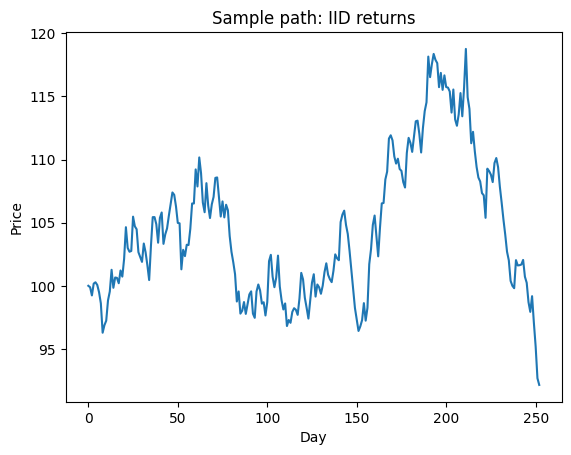

In [73]:
plt.figure(); plt.plot(S_iid[0]); plt.title("Sample path: IID returns"); plt.xlabel("Day"); plt.ylabel("Price"); plt.show()

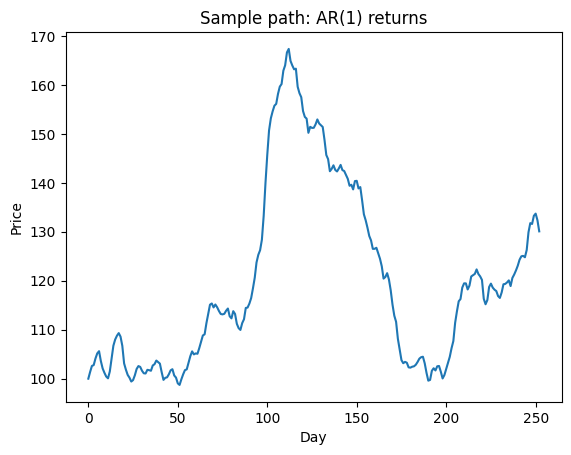

In [74]:
plt.figure(); plt.plot(S_ar1[0]); plt.title("Sample path: AR(1) returns"); plt.xlabel("Day"); plt.ylabel("Price"); plt.show()

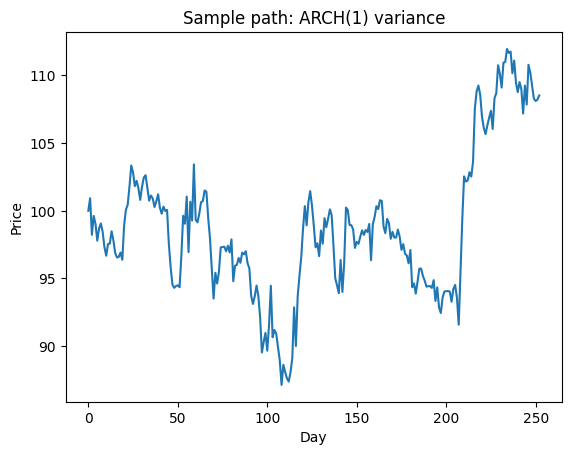

In [75]:
plt.figure(); plt.plot(S_arch[0]); plt.title("Sample path: ARCH(1) variance"); plt.xlabel("Day"); plt.ylabel("Price"); plt.show()

### Knowledge check 5.C
1) Which model tends to produce the largest Monte Carlo standard error, and why?  
2) How does increasing the AR(1) coefficient affect effective sample size?  
3) Why can ARCH(1) increase short-horizon tail risk relative to iid?


In [76]:
# @title
#print("1) Strong AR(1) and ARCH(1) often increase SE due to dependence or volatility clustering.")
#print("2) Higher persistence reduces effective sample size; slower convergence.")
#print("3) Time-varying conditional variance clusters large moves, thickening tails.")

## 6. Homework
Due 10/24 by 11:59PM


**Q1.** Create a series with both trend and seasonality. Plot it and its ACF. Report the seasonal period.  

**Explanation:**
<font color="#66FFoo">  



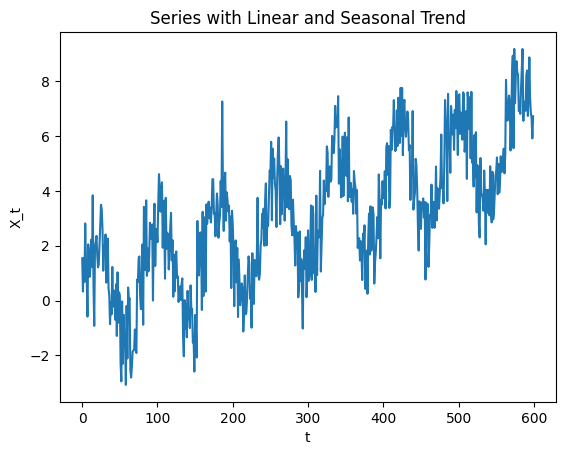

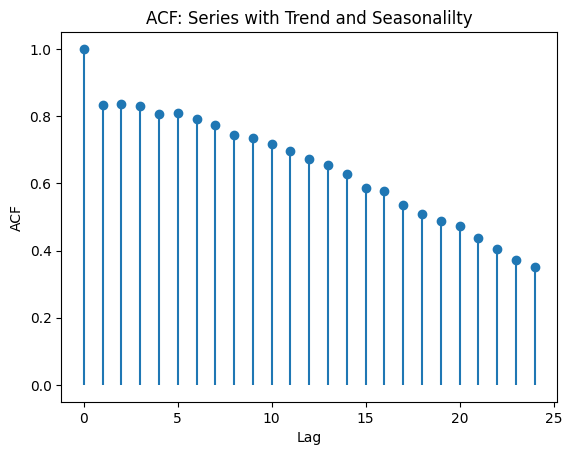

Positive ACF because small values clump (early time) and large values clump (later times)


In [77]:
#code for Q1

SEASON_PERIOD = 80

t = np.arange(N)
season = 2.0 * np.sin(2*np.pi*t/SEASON_PERIOD)
trend = 0.01 * t
noise = np.random.normal(0, SIGMA, N)

series_trend_seasonality = trend + season + noise

# Plot the time series
lineplot(series_trend_seasonality, title="Series with Linear and Seasonal Trend", xlabel="t", ylabel="X_t")

# Updated ACF plot function for compatibility
def acf_plot(x, max_lag=24, title=None):
    acf = acf_values(x, max_lag=max_lag)
    lags = np.arange(max_lag + 1)
    plt.figure()
    # remove deprecated argument
    plt.stem(lags, acf, basefmt=" ")
    if title:
        plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.show()

# Plot ACF for the series
acf_plot(series_trend_seasonality, max_lag=24, title="ACF: Series with Trend and Seasonalilty")
print("Positive ACF because small values clump (early time) and large values clump (later times)")


**Q2.** Simulate 10 series each of white noise, random walk, and ARIMA(1,1,0). For each, examine mean of first differences and comment on stationarity.  

**Explanation:**
<font color="#66FFoo">  
After doing some simulations, the means of the first differences for each of the 3 models all stay around 0. However, we know that the random walk and ARIMA models are not stationary, so the mean of first differences doesn't give us information about stationarity.
<font color="#66FFoo">  
The variance gives information about stationarity, a stationary model will have a constant variance while a non-stationary model will change over time.



In [78]:
#code for Q2
import pandas as pd

N = 600
S = 10
SIGMA = 1

df = pd.DataFrame(columns=['White Noise', 'Random Walk', 'ARIMA(1,1,0)'])

white_noise_data = []
rw_data = []
ar_data = []

for i in range(S):
  white_noise = np.random.normal(0, SIGMA, N)

  rw = np.zeros(N)
  eps = np.random.normal(0, SIGMA, N)
  for s in range(1, N):
      rw[s] = rw[s-1] + eps[s]

  phi = .5
  eps = np.random.normal(0, SIGMA, N)
  dX = np.zeros(N)
  for j in range(1, N):
      dX[j] = phi * dX[j-1] + eps[j]

  white_noise_data.append(np.mean(np.diff(white_noise)))
  rw_data.append(np.mean(np.diff(rw)))
  ar_data.append(np.mean(np.diff(dX)))

df['White Noise'] = white_noise_data
df['Random Walk'] = rw_data
df['ARIMA(1,1,0)'] = ar_data

print(df)

print("Mean of first differences:")
print("White Noise:", np.mean(df['White Noise']))
print("Random Walk:", np.mean(df['Random Walk']))
print("ARIMA(1,1,0):", np.mean(df['ARIMA(1,1,0)']))




   White Noise  Random Walk  ARIMA(1,1,0)
0     0.000597     0.012259      0.001079
1     0.000831    -0.050479      0.000681
2    -0.000938    -0.155753     -0.001360
3     0.000312    -0.062876      0.002628
4    -0.000560    -0.038863      0.003437
5     0.000837    -0.050061     -0.000721
6     0.001841    -0.045133     -0.000450
7    -0.000554     0.020869     -0.002618
8     0.001297     0.072369      0.002456
9     0.001574    -0.032247      0.001509
Mean of first differences:
White Noise: 0.0005238166408429154
Random Walk: -0.03299140924940521
ARIMA(1,1,0): 0.0006641068269017631


**Q3.** Simulate ARCH(1) with alpha in {0.2, 0.5, 0.8}. Plot ACF of squared values; discuss persistence.  

**Explanation:**
<font color="#66FFoo">  
Persistence describes the extent volatility is impacted by extreme values (volatility shocks). In ARCH(1), a higher alpha will result in longer volatility shocks.

The plots show this in action, we can see that the ARCH(1) plot with alpha = 0.2 has much lower variance than the plot with alpha = 0.8.


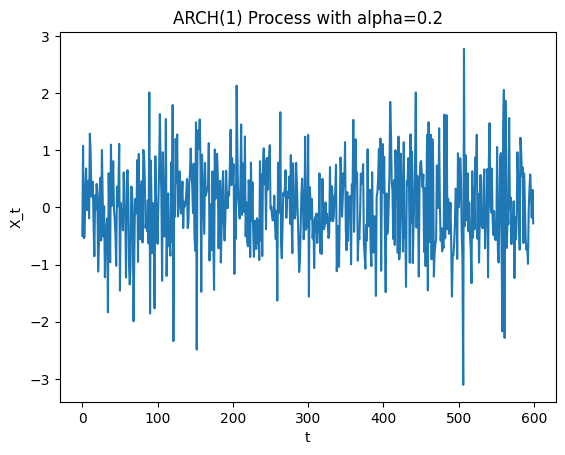

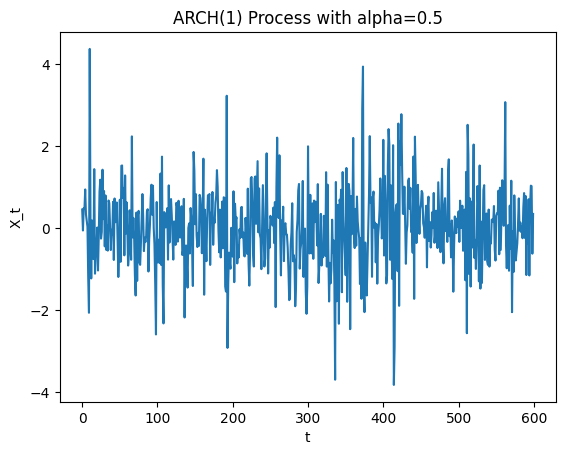

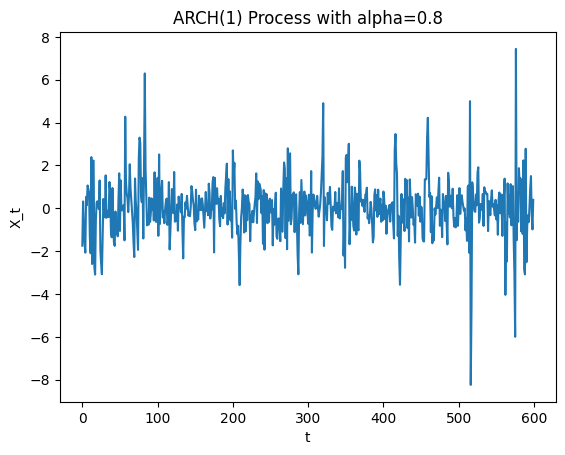

In [79]:
#code for Q3

alpha = [0.2, 0.5, 0.8]

for a in alpha:
  omega = 0.5
  alpha = a
  z = np.random.normal(0, 1, N)
  sigma2 = np.zeros(N)
  x_arch = np.zeros(N)
  sigma2[0] = omega/(1-alpha) if alpha < 1 else 1.0
  x_arch[0] = np.sqrt(sigma2[0]) * z[0]
  for j in range(1, N):
      sigma2[j] = omega + alpha * (x_arch[j-1]**2)
      x_arch[j] = np.sqrt(sigma2[j]) * z[j]

  lineplot(x_arch, title=f"ARCH(1) Process with alpha={a}", xlabel="t", ylabel="X_t")



**Q4.** Re-run the option pricing demo with M=50,000. Compare prices and standard errors; explain differences.  

**Explantion:**
<font color="#66FFoo">  
Running 50,000 simulations instead of 20,0000 resulted in similar prices but tigher standard errors. 20,000 simulations is already a lot, running 30,000 more won't have a huge effect on the price results because of the law of large numbers. However, it will impact the standard error range because a higher sample size will result in less variance of results and a tighter interval to estimate the true price.

SE = sigma / sqrt(sample size)

In [84]:
#code for Q4

M = 50_000
phi = 0.6

S_iid,  R_iid  = simulate_prices_iid (M, T_days, S0, sigma_ann=sigma_ann, dt=dt)
S_ar1,  R_ar1  = simulate_prices_ar1 (M, T_days, S0, phi=phi, sigma_ann=sigma_ann, dt=dt)
S_arch, R_arch = simulate_prices_arch1(M, T_days, S0, alpha=alpha_arch, sigma_ann=sigma_ann, dt=dt, burn=burn_arch)

p_iid,  se_iid  = european_call_mc(S_iid,  K, r, dt)
p_ar1,  se_ar1  = european_call_mc(S_ar1,  K, r, dt)
p_arch, se_arch = european_call_mc(S_arch, K, r, dt)

print(f"Realized σ (annual): iid={realized_ann_vol(R_iid, dt):.3f}, ar1={realized_ann_vol(R_ar1, dt):.3f}, arch={realized_ann_vol(R_arch, dt):.3f}")
print(f"IID:   price={p_iid:.4f},  SE={se_iid:.4f}")
print(f"AR(1): price={p_ar1:.4f},  SE={se_ar1:.4f}  (phi={phi})")
print(f"ARCH:  price={p_arch:.4f},  SE={se_arch:.4f}  (alpha={alpha_arch})")


Realized σ (annual): iid=0.200, ar1=0.199, arch=0.200
IID:   price=8.9194,  SE=0.0618
AR(1): price=20.4454,  SE=0.1501  (phi=0.6)
ARCH:  price=8.9170,  SE=0.0623  (alpha=0.5)


**Prices and SE's when M = 20,000**

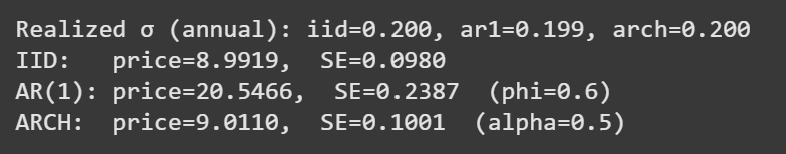

**Q5.** Short write-up: Implications for VaR and option pricing when true returns are autocorrelated or volatility-clustered.

**Explanation:**
<font color="#66FFoo">  

Normal VaR and common options pricing models like Black Scholes have some key assumptions that are often unrealistic to real return data. Such as:
- Assumption of indpendence
- Sampled from a Normal distribution (thinner tails)
- Constant Volatility

If true returns are positively autocorrelated, the VaR will underestimate returns and overestimate if there's a negative correlation. The Black Scholes model will also suffer because the GBM won't account for the correlation.

If true returns are volatility-clustered, VaR will be affected depending on the timing of the volatility clusters and the time that VaR is measured. VaR and Black Scholes assume constant volatility and thinner tails, volatility clustering produces fatter tails. As a result, VaR may underestimate tail risk and Black Scholes may misprice options.